In [1]:
import sys
sys.path.insert(0, '../../../')

import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [5]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        folds=10,
                        random_state=42,
                        feature_bag=False
                       )
df = df[df.h_target == 0]

In [6]:
red_class = [classes[i] for i in df.target.unique()]

In [7]:
df.metadata = [meta.values for meta in df.metadata]

In [8]:
df.head()

,target,h_target,metadata,fold
0,0,0,"[[29.566979172606093, 38.58167275085112, 23.17...",6
1,14,0,"[[36.08755307592971, 42.38545791960979, 41.323...",9
8,9,0,"[[145.62651783720446, 57.488502523299886, 50.8...",9
14,0,0,"[[12.888009439928263, 11.501477524068855, 9.79...",10
29,8,0,"[[111.59686602000662, 86.6156218997384, 61.087...",1


In [9]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df[df.fold != 1], test_size=0.20, random_state=42)

In [10]:
train_X = train.metadata.values
train_y = train['target']
test_X = test.metadata.values
test_y = test['target']

In [11]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
train_X = pad_sequences(train_X, padding='post', maxlen=50)

# Training

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(50,129)))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    model.add(Dense(18, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [14]:
# scaler = MinMaxScaler()
# train_X = scaler.fit_transform(train_X)
# feat_red = PCA(n_components=30)
# feat_red.fit(train_X,y=train_y)
# train_X = feat_red.transform(train_X)

clf = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=32, 
                       batch_size=16, 
                       validation_split=0.15)

history = clf.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           92000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 100)           80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
__________

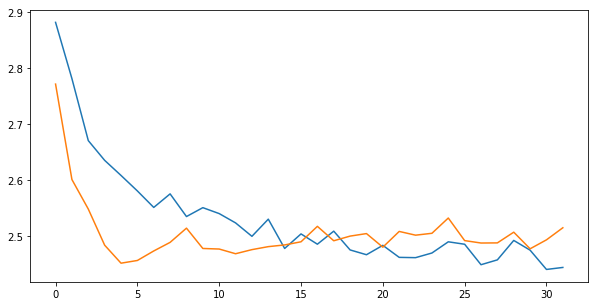

In [15]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

0.16030534351145037
Confusion matrix, without normalization
[[0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 2 0 0]
 [0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 2 0 0 2 0 0 0 0 0 3 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 5 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 2 0 1 0 0]
 [0 0 0 0 3 2 0 0 0 0 1 0 2 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 8 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 6 0 2 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [1 1 0 0 1 0 0 0 0 0 1 0 5 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 3 0 0 1 0 0 0 0 0 3 0 1 1 0 2 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 1 0 0 2 3 0 0 0 0 2 1 1 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1]]


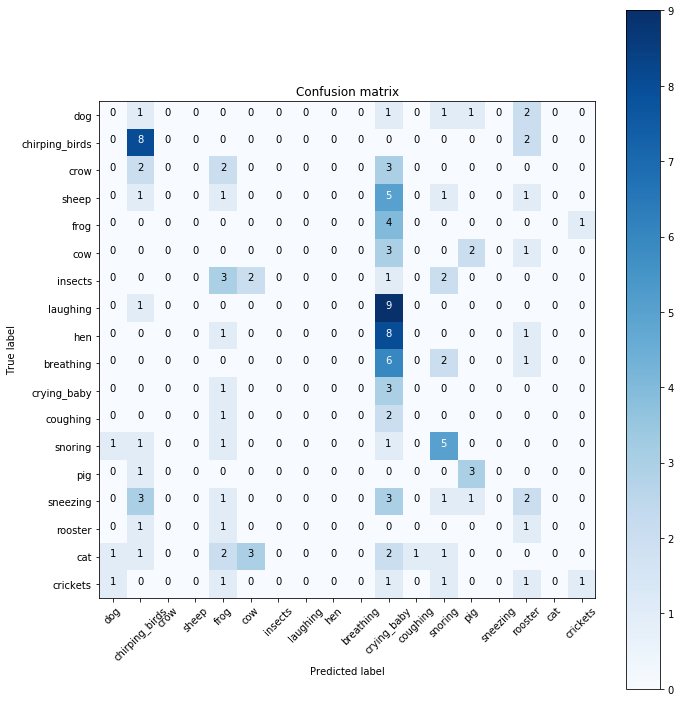

In [16]:
# test_X = scaler.transform(test_X)
# test_X = feat_red.transform(test_X)

test_X = pad_sequences(test_X, padding='post', maxlen=50)

pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, red_class)
plt.show()

# All Data

In [17]:
all_df = df[df.fold == 1]

In [18]:
all_df.head()

,target,h_target,metadata,fold
29,8,0,"[[111.59686602000662, 86.6156218997384, 61.087...",1
49,3,0,"[[97.27983999180738, 39.69683572214732, 32.512...",1
69,4,0,"[[69.85579177171586, 26.40174942381776, 26.495...",1
70,6,0,"[[70.08767015063766, 44.9062035948112, 12.2601...",1
99,2,0,"[[82.19326815331567, 39.52594125212301, 50.064...",1


In [19]:
X = all_df.metadata.values
y = all_df['target']
# X = scaler.transform(X)
# X = feat_red.transform(X)
X = pad_sequences(X, padding='post', maxlen=50)

0.18840579710144928
Confusion matrix, without normalization
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 2 1 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 1 0 1]
 [0 0 0 0 2 1 0 0 0 0 1 0 0 0 0 1 0 1]
 [0 1 0 0 0 1 0 0 0 0 2 0 0 0 0 2 0 0]
 [0 0 0 0 2 0 0 0 0 0 2 0 1 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 3 0 1 0 0]
 [0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0]]


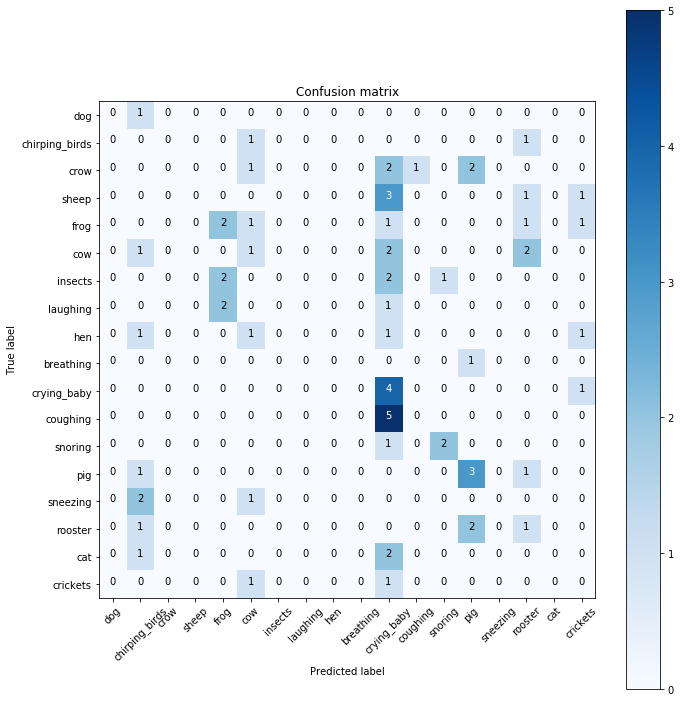

In [20]:
pred = clf.predict(X)
pred_prob = clf.predict_proba(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, red_class)
plt.show()

In [21]:
import seaborn as sns
misclassified = {
    'actual': [],
    'predicted': []
}
for cls in red_class:
    misclassified[cls] = []

for row, p, prob, Y in zip(all_df.iterrows(), pred, pred_prob, y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['actual'].append(classes[int(row[1]['target'])])
        misclassified['predicted'].append(classes[p])
        for i, cls in enumerate(red_class):
            misclassified[cls].append(prob[i])

misclassified = pd.DataFrame.from_dict(misclassified)
misclassified.head()

,actual,breathing,cat,chirping_birds,coughing,cow,crickets,crow,crying_baby,dog,frog,hen,insects,laughing,pig,predicted,rooster,sheep,sneezing,snoring
0,sheep,0.008876,0.002719,0.003867,0.011250,0.121184,0.406558,0.062654,0.097920,0.021010,0.118075,0.004442,0.019478,0.005595,0.063120,snoring,0.034841,0.004360,0.007311,0.006740
1,cow,0.032436,0.012007,0.097665,0.026639,0.126782,0.083691,0.062939,0.008197,0.131022,0.013517,0.010933,0.015480,0.021756,0.080822,coughing,0.164945,0.064100,0.040621,0.006449
2,hen,0.057097,0.087981,0.004812,0.057498,0.025705,0.035535,0.034627,0.068004,0.022387,0.188341,0.040744,0.123390,0.062199,0.009543,frog,0.015432,0.025676,0.032610,0.108417
3,pig,0.090598,0.025397,0.002817,0.134537,0.025195,0.008903,0.051496,0.176552,0.015677,0.050791,0.131198,0.051367,0.119845,0.004918,crickets,0.007070,0.054609,0.036291,0.012739
4,pig,0.090598,0.025397,0.002817,0.134537,0.025195,0.008903,0.051496,0.176552,0.015677,0.050791,0.131198,0.051367,0.119845,0.004918,crickets,0.007070,0.054609,0.036291,0.012739


In [22]:
average_prob = misclassified.groupby('predicted').mean()
average_prob.head()

,breathing,cat,chirping_birds,coughing,cow,crickets,crow,crying_baby,dog,frog,hen,insects,laughing,pig,rooster,sheep,sneezing,snoring
predicted,,,,,,,,,,,,,,,,,,
cat,0.053670,0.004194,0.004293,0.046604,0.284765,0.090417,0.090385,0.055153,0.052314,0.094991,0.036080,0.066792,0.031399,0.009241,0.009882,0.013450,0.036459,0.019911
chirping_birds,0.089549,0.010275,0.003645,0.142330,0.072088,0.033541,0.087174,0.121782,0.027379,0.051759,0.102086,0.080796,0.070452,0.005279,0.006840,0.031119,0.046421,0.017484
coughing,0.032436,0.012007,0.097665,0.026639,0.126782,0.083691,0.062939,0.008197,0.131022,0.013517,0.010933,0.015480,0.021756,0.080822,0.164945,0.064100,0.040621,0.006449
crickets,0.089591,0.027995,0.002899,0.131492,0.025842,0.009670,0.052334,0.172326,0.015899,0.055019,0.128238,0.053144,0.119650,0.005099,0.007402,0.053038,0.036082,0.014281
crying_baby,0.038867,0.103083,0.030373,0.028291,0.021182,0.066907,0.035897,0.022452,0.117279,0.036289,0.036949,0.055542,0.029260,0.010692,0.042308,0.052239,0.084036,0.188354


In [23]:
average_prob = misclassified.groupby('actual').mean()
average_prob

,breathing,cat,chirping_birds,coughing,cow,crickets,crow,crying_baby,dog,frog,hen,insects,laughing,pig,rooster,sheep,sneezing,snoring
actual,,,,,,,,,,,,,,,,,,
breathing,0.053711,0.030731,0.129080,0.027890,0.141828,0.082648,0.059998,0.020035,0.079653,0.047541,0.016817,0.038429,0.021005,0.024326,0.079923,0.088082,0.037976,0.020325
cat,0.061222,0.029232,0.074044,0.068614,0.066838,0.050952,0.052736,0.074996,0.076698,0.029069,0.059908,0.034376,0.060917,0.037995,0.091358,0.071916,0.042353,0.016776
chirping_birds,0.090598,0.025397,0.002817,0.134537,0.025195,0.008903,0.051496,0.176552,0.015677,0.050791,0.131198,0.051367,0.119845,0.004918,0.007070,0.054609,0.036291,0.012739
coughing,0.022505,0.026336,0.061451,0.012845,0.085660,0.030773,0.024585,0.004315,0.099148,0.015328,0.007006,0.015801,0.027643,0.292284,0.179372,0.043405,0.035011,0.016531
cow,0.063386,0.018294,0.022027,0.088772,0.070065,0.084614,0.058628,0.126861,0.042975,0.060927,0.082102,0.038909,0.078053,0.031045,0.043946,0.046635,0.032002,0.010756
crickets,0.009417,0.002805,0.003823,0.011421,0.121225,0.378518,0.067992,0.101170,0.023897,0.127749,0.004661,0.020929,0.006243,0.065867,0.035085,0.004401,0.007573,0.007222
crow,0.002729,0.003180,0.005281,0.006343,0.104827,0.007306,0.019086,0.003183,0.109194,0.016361,0.002773,0.004769,0.031406,0.458826,0.201616,0.002930,0.018276,0.001912
crying_baby,0.083124,0.056458,0.003734,0.090280,0.029182,0.015375,0.053739,0.133000,0.017430,0.098285,0.100811,0.067779,0.128893,0.007052,0.010812,0.040620,0.033573,0.029853
dog,0.056538,0.035357,0.187993,0.027781,0.052645,0.079371,0.054982,0.006937,0.097170,0.015754,0.013736,0.023729,0.019192,0.036908,0.112090,0.125328,0.037572,0.016917


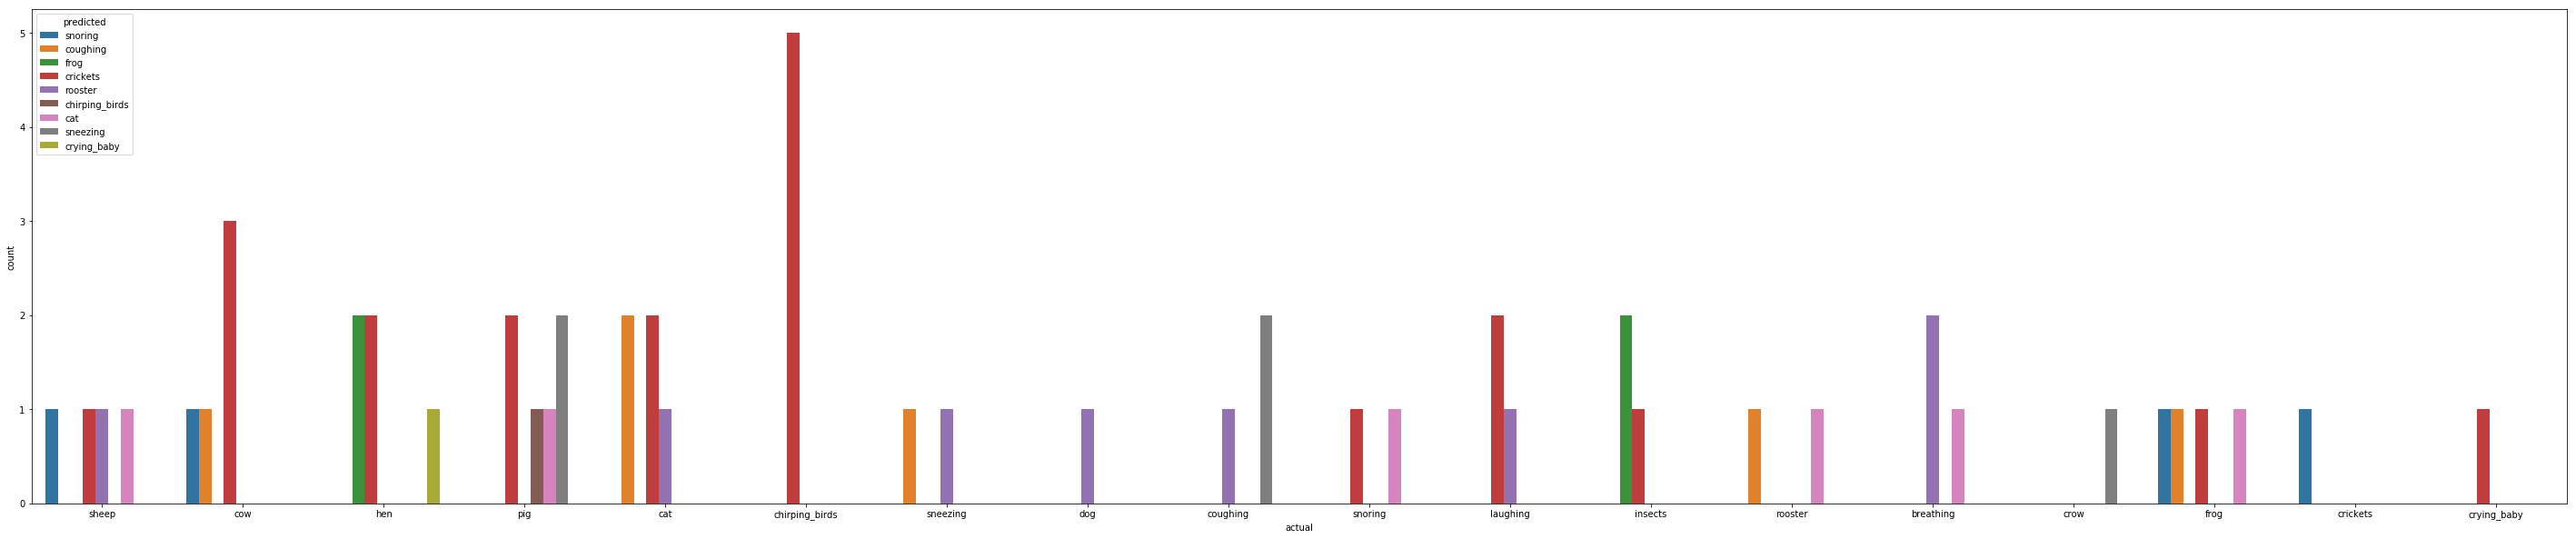

In [24]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='actual', hue='predicted',data=misclassified)